<a href="https://colab.research.google.com/github/HwangSiyeon/ESAA_homework/blob/main/ESAA_HW_0311_ModelTraining_RegressionRidgeLassoElasticnetLogistic_HandsOnML_157_202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델 훈련

- 작동 원리에 대해 잘 이해하고 있으면 디버깅이나 에러를 효율적으로 분석하는 데에 도움이 된다.
- 이 장에서는 대부분 신경망을 이해하고 구축하고 훈련하는 데 필수적인 부분을 선형회귀를 통해 다룬다.
- 훈련세트에 대해 비용함수를 최소화하는 모델 파라미터를 해석적으로 구한다.
- 경사 하강법(GD)라 불리는 반복적인 최적화 방식을 사용해 모델 파라미터를 조금씩 바꾸면서 비용함수를 훈련세트에 대해 최소화시킨다. 이외에 배치경사하강법, 미니배치경사하강법, 확률적경사하강법을 살펴본다
---
- 이외에 비선형 데이터셋에 훈련시킬 수 있는 다항회귀를 살펴본다. 다항회귀는 선형회귀보다 파라미터가 많아 과대적합되기 쉽다.
- 이를 해결하기 위해 훈련 세트의 과대적합을 감소시킬 수 있는 규제 기법을 알아본다.
---
- 마지막으로 분류작업에 널리 사용하는 모델인 로지스틱 회귀와 소프트맥스 회귀를 살펴본다.

## 4.1 선형회귀
- 일반적으로 선형 모델은 입력특성의 가중치합과 편향(bias)라는 상수를 더해 예측을 만든다.
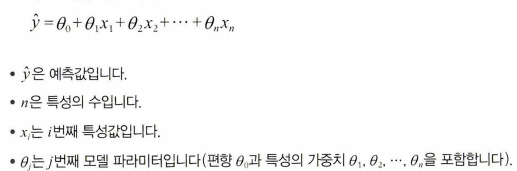

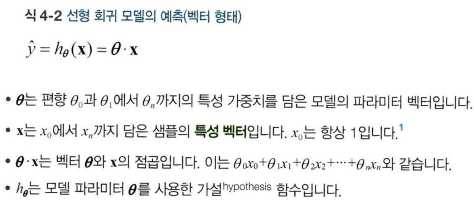

- 머신러닝에서는 종종 벡터를 하나의 열을 가진 2D 배열인 열벡터로 나타낸다.
- 회귀에서 가장 널리 사용되는 지표는 RMSE(평균제곱근오차)이다.
- 선형회귀모델을 훈련시키려면 RMSE를 최소화하는 파라미터를 찾아야 한다.
- 실제로는 RMSE보다 MSE(평균제곱오차)를 최소화하는 것이 같은 결과를 내면서 더 간단하다.

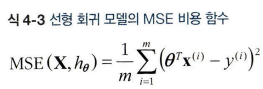

### 4.1.1 정규방정식
- 비용합수를 최소화하는 세타값을 찾기 위한 **해석적인 방법**이 있다. 다른 말로 하면 바로 결과를 얻을 수 있는 수학공식이다. 이를 **정규방정식**이라고 한다.

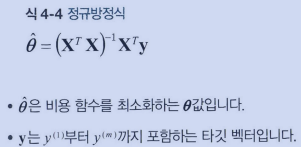

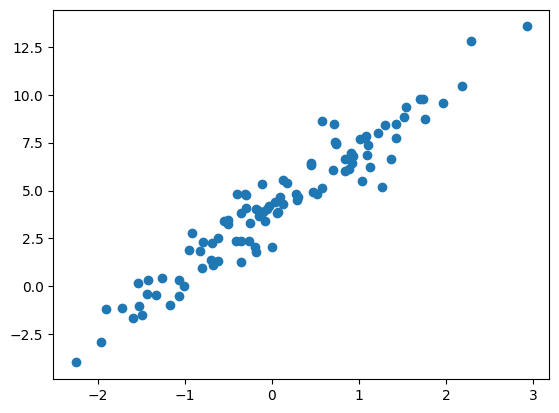

In [4]:
# 위 공식을 테스트하기 위해 선형으로 보이는 데이터를 생성한다.
import numpy as np
import matplotlib.pyplot as plt

X = np.random.randn(100,1)
y= 4+3*X +np.random.randn(100,1)
plt.scatter(X,y) # 내가 임의로 그린 그림

- 이제 정규방정식을 사용해 세타의 예측값를 계산해본다.
- inv( ) : 역행렬 계산
- dot( ) : 행렬곱셈

In [5]:
X_b = np.c_[np.ones((100,1)),X] # 모든 샘플에 x0=1 을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [6]:
theta_best

array([[4.06929288],
       [3.1197044 ]])

- (4,3)을 기대했지만 잡음때문에 원래 함수의 파라미터를 정확하게 재현하지 못했다
- 세타의 예측값을 사용해 예측을 해보겠다

In [7]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.06929288],
       [10.30870168]])

- 모델의 예측을 그래프에 나타내본다

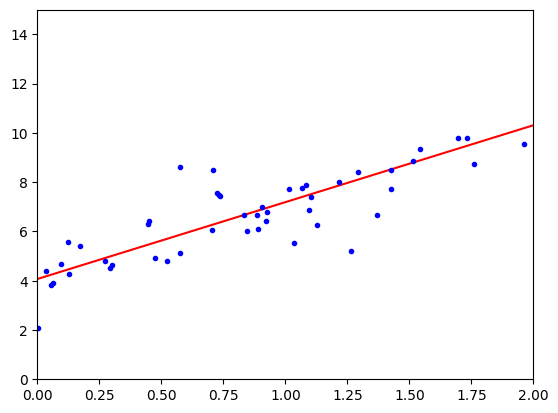

In [8]:
plt.plot(X_new,y_predict, "r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.show()

- 사이킷런에서 선형회귀를 수행해본다

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)

[4.06929288] [[3.1197044]]


array([[ 4.06929288],
       [10.30870168]])

- LinearRegression 클래스는 scipy.linalg.lsts() 함수(최소제곱least squares에서 이름을 따옴)를 기반으로 한다.
- 이 함수를 직접 호출할 수 있다.

In [10]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b,y,rcond=1e-6)
theta_best_svd

array([[4.06929288],
       [3.1197044 ]])

이 함수는 다음 식을 계산한다.
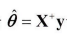

- 여기서 X+는 X의 유사역행렬이다(무어-펜로즈 역행렬)
- np.linalg.pinv()함수를 통해 유사역행렬을 직접 구할 수 있다.

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.06929288],
       [3.1197044 ]])

- 유사역행렬 자체는 **특이값분해(SVD)**라 부르는 표준행렬분해기법을 사용해 계산된다.

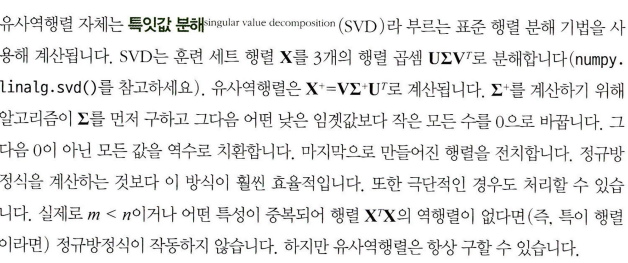

## 4.2 경사 하강법
- 경사하강법(GD)은 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘이다.
- 경사하강법의 기본 아이디어는 비용함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것이다.
- 파라미터 벡터 세타에 대해 비용함수의 현재 그라디언트를 계산한 후, 그라디언트가 감소하는 방향으로 진행한다. 그라디언트가 0이 되면 최솟값에 도달한 것이다.
- 세타를 임의의 값으로 시작해서 **무작위 초기화**하여 한번에 조금씩 비용함수가 감소되는 방향으로 진행하여 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상시킨다.

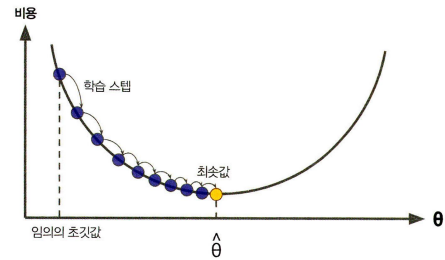

- 경사하강법에서 중요한 파라미터는 스템의 크기로, **학습률** 하이퍼 파라미터로 결정된다.
- 학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간이 오래 걸린다.

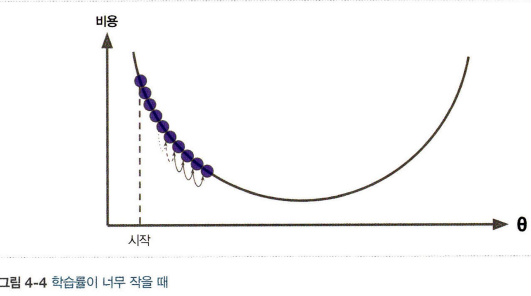

- 학습률이 너무 크면 알고리즘을 더 큰 값으로 발산하게 만들어 적절한 해법을 찾지 못할 수도 있다.

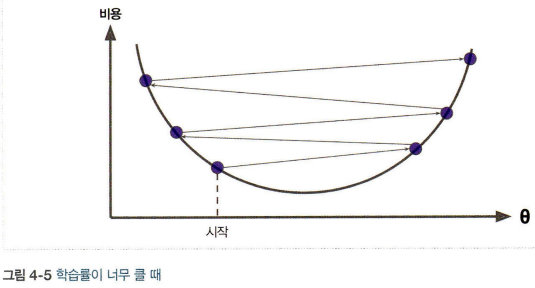

- 모델 훈련은 비용함수를 최소화하는 모델 파라미터의 조합을 찾는 일이다. 이를 모델의 **파라미터 공간**에서 찾는다고 말한다. 모델이 가진 파라미터가 많을수록 이 공간의 차원은 커지고 검색이 더 어려워진다.
- 선형회귀의 경우 비용함수가 볼록함수이기 때문에 최적의 지점은 그릇모양 그래프의 맨 아래에 있을 것이다.

### 4.2.1 배치경사하강법
- 경사하강법을 구현하려면 각 모델 파라미터 세타에 대해 비용함수의 그레디언트를 계산해야 한다.
- 다시 말해 세타값 중 한 원소가 조금 변경될 때 비용함수가 얼마나 바뀌는지 계산해야 한다. 이를 **편도함수**라고 한다.

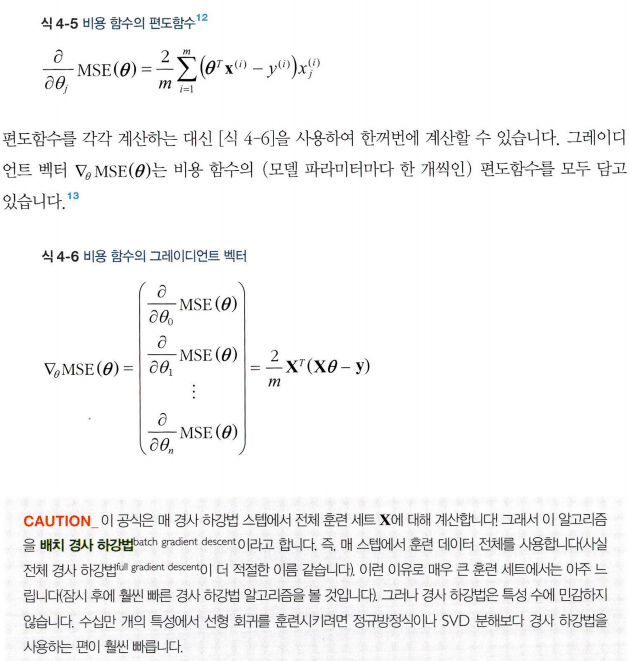


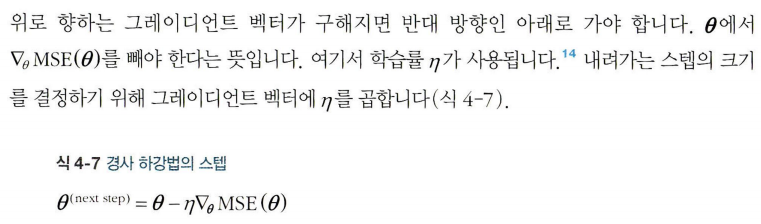

In [12]:
eta = 0.1 # 학습률
n_iterations =1000
m=100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

In [13]:
theta

array([[4.06929288],
       [3.1197044 ]])

- 정규방정식으로 찾은 것과 정확히 같다. 경사하강법이 완벽하게 작동했다
- 학습률을 바꿔보면 다음과 같은 결과가 나온다.



- 왼쪽은 학습률이 너무 낮다. 최적점에 도달하는 데 시간이 오래 걸린다. 가운데는 학습률이 적당하다. 반복 몇번만에 최적점에 수렴한다. 오른쪽은 학습률이 너무 높다. 알고리즘이 이리저리 널뛰면서 스텝마다 최적점에서 점점 멀어져 발산한다.
- 적절한 학습률을 찾기 위해 그리드탐색을 사용한다. 하지만 그리드 탐색에서 수렴하는데 너무 오래 걸리는 모델을 막기 위해 반복 횟수를 제한해야 한다.
- 반복 횟수는 아주 크게 지정하고 그라디언트 벡터가 아주 작아지면, 즉 벡터의 노름이 어떤 값 E(허용오차tolerance)보다 작아지면 경사하강법이 최솟값에 도달한 것이므로 알고리즘을 중지한다.

### 4.2.2 확률적 경사하강법
- 경사하강법의 가장 큰 문제는 매 스탭에서 전체 훈련세트를 사용해 그레디언트를 계산한다는 사실이다. 훈련세트가 커지면 매우 느려지는 문제가 발생한다.
- **확률적 경사하강법**에서는 매 스탭에서 한개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그라디언트를 계산한다.
- 장점: 확률적 경사하강법은 매 스탭에서 한개의 데이터를 무작위로 선택하고 그 하나의 샘플만 메로리에 있으면 되므로 큰 훈련세트도 훈련시킬 수 있다. 또한, 매 반복에서 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련세트도 훈련시킬 수 있다.
- 단점: 확률적, 즉 무작위이기 때문에 배치경사하강법보다 훨씬 불안정하다. 최솟값에 매우 근접하겠지만 요동이 지속되면서 최솟값에 안착하지는 못할 것이다. 알고리즘이 멈출 때 좋은 파라미터가 구해지겠지만 최적치는 아니다
- 비용함수가 매우 불규칙할 경우 알고리즘이 지역 최솟값을 건너뛸 수 있도록 도와주므로 확률적 경사하강법이 배치하강법보다 전역 최솟값을 찾을 가능성이 높다.
- 무작위성은 지역 최솟값에서 탈출시켜줘서 좋지만 알고리즘을 전역 최솟값에 다다르지 못하게 한다는 점에서는 좋지 않다. 이 딜레마를 해결하는 한가지 방법은 학습률을 점진적으로 감소시키는 것이다. 시작할 때는 학습률을 크게 하고 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 한다. 이 과정은 금속분야에서 **담금질 기법**과 유사하다. 매 반복에서 학습률을 결정하는 함수를 **학습 스케줄**이라고 부른다.

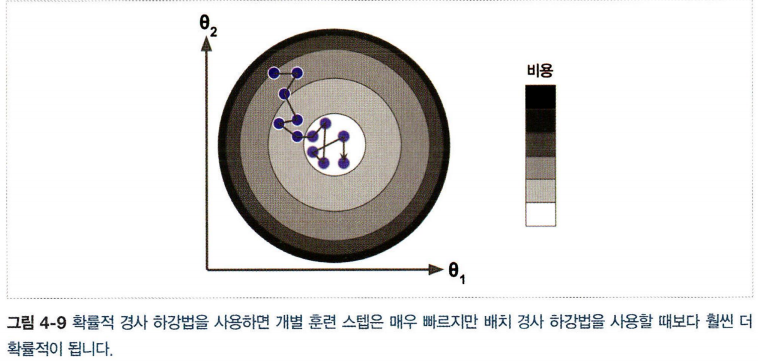

In [14]:
# 다음 코드는 간단한 학습스케줄을 사용한 확률적 경사하강법의 구현이ㅏㄷ.
n_epochs = 50
t0,t1 = 5,50
def learning_schedule(t):
  return t0/(t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs): # 한 반복에서 m번 되풀이된다. 이 때 각 반복을 epoch라고 한다.
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index : random_index +1]
    yi = y[random_index : random_index +1]
    gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

- 배치경사하강법 코드가 전체 훈련세트에 대해 1000번 반복하는 동안 이 코드는 훈련세트에서 50번만 반복하고도 매우 좋은 값에 도달했다

In [15]:
theta

array([[4.03037969],
       [3.1357238 ]])

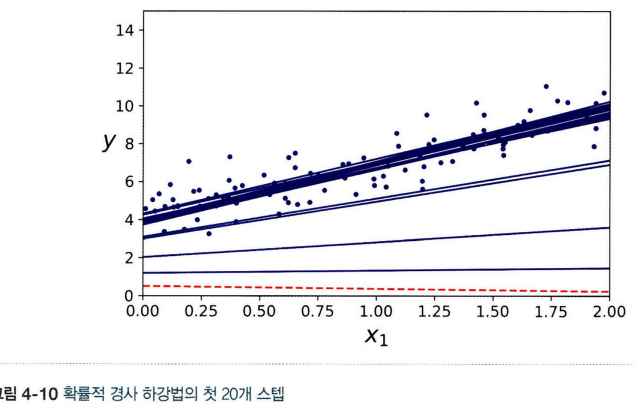

- 위의 그림에서 스텝이 불규칙하게 진행함을 알 수 있다.
- 샘플을 무작위로 선택하기 때문에 어떤 샘플은 한 에포크에서 여러번 선택될 수 있고 어떤 샘플은 전혀 선택되지 못할 수도도 있다.알고리즘이 에포크마다 모든 샘플을 사용하게 하려면 훈련 세트를 섞은 후(입력 특성과 레이블을 동일하게 섞어야 한다. 차례대로 하나씩 선택학 다음 에포크에서 다시 섞는 식의 방법을 사용할 수 있다. 그러나 이렇게 하면 보통 더 늦게 수렴된다.
- 사이킷런에서 SGD 방식으로 선형회귀를 사용하려면 기본값으로 제곱오차비용함수를 최적화하는 SGDRegressor 클래스를 사용한다.
- 다음 코드는 최대 1000번 에포크동안 실행된다(max_iter=1000). 또는 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행된다(tol=1e-3). 학습률 0.1(eta0=0.1)로 이전과 달리 기본 학습스케툴을 사용한다. 규제는 전혀 사용하지 않았다. (penalty=None)

In [16]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_  # 정규방정식으로 구한 것과 비슷한 값이다

(array([4.09237137]), array([3.18153667]))

### 4.2.3 미니배치 경사하강법
- 전체 훈련세트나 하나의 샘플을 기반으로 그레디언트를 계산하는 것이 아니라 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레디언트를 계산한다. 확률적 경사하강법에 비해 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 성능향상을 도모할 수 있다.

- 특히 미니배치를 어느 정도 크게 하면 이 알고리즘은 파라미터 공간에서 SGD보다 덜 불규칙하게 움직인다. 결국 미니배치 경사하강법이 SGD보다 최솟값에 더 가까이 도달하게 될 것이다. 하지만 지역 최솟값에서 빠져나오기는 더 힘들지도 모른다(선형회귀와 같지 않고 지역 최솟값이 문제가 되는 경우). 아래 그림은 세가지 경사하강법 알고리즘이 훈련 과정동안 파라미터 공간에서 움직인 경로이다. 모두 최솟값 근처에 도달했지만 배치경사하강법의 경로가 실제로 최솟값에서 멈춘 반면 확률적 경사하강법과 미니배치 경사하강법은 근처에서 맴돌고 있다. 그렇지만 배치 경사 하강법에는 매 스텝에서 많은 시간이 소요되고, 확률적 경사하강법과 미니배치 경사하강법도 적절한 학습스케줄을 사용하면 최솟값에 도달한다는 것을 잊지 말아야 한다.

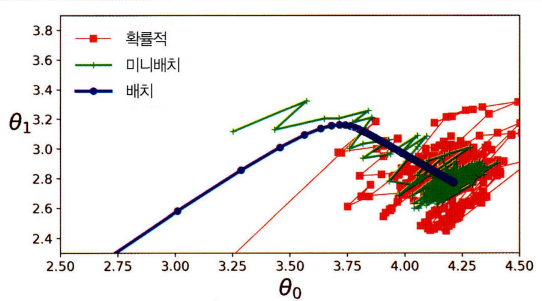

- 지금까지 논의한 알고리즘을 선형회귀를 사용해 비교해보겠다(m은 훈련샘플 수이고 n은 특성 수이다).

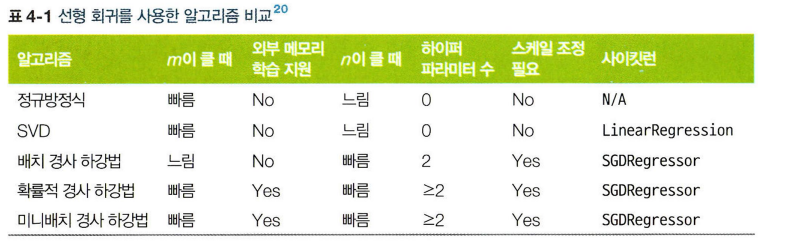

## 4.3 다항회귀
- 비선형 데이터를 학습하는 데 선형모델을 사용할 수 있다. 이렇게 하는 간단한 방법은 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것입니다. 이런 기법을 **다향회귀**라고 합니다.

- 2차방정식의 비선형 데이터셋의 예를 들어보겠다.

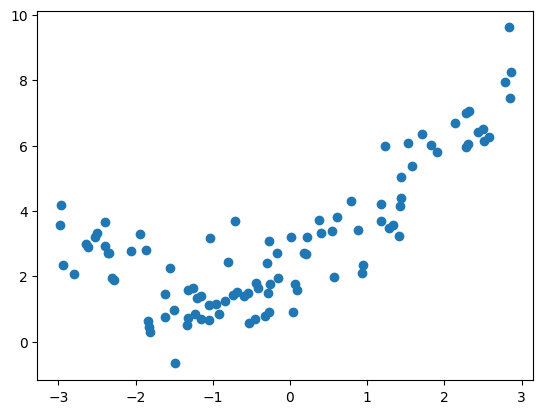

In [21]:
m = 100
X= 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)
plt.scatter(X,y)

- 사이킷런의 PolynominalFeatures를 사용해 훈련데이터를 변환해보겠다. 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가한다(여기서는 특성 하나가 추가된다).

In [23]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
X_poly[0]

[0.40204679]


array([0.40204679, 0.16164162])

- X_poly는 이제 원래 특성 X와 이 특성의 제곱을 포함합니다. 이 확장된 훈련데이터에 Linear Regression을 적용해본다.

[2.06162245] [[0.95703098 0.44624924]]


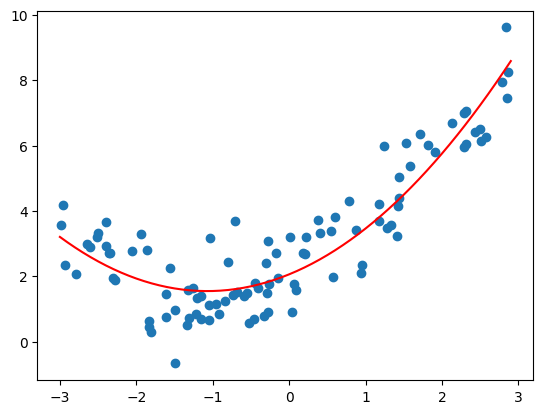

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
print(lin_reg.intercept_, lin_reg.coef_)
plt.scatter(X,y)
x = np.arange(-3,3,0.1)
plt.plot(x, lin_reg.intercept_[0]+lin_reg.coef_[0][0]*x+ lin_reg.coef_[0][1]*x**2, "r")

- 특성이 여러개일때 다항회귀는 이 특성 사이의 관계를 찾을 수 있다. PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문이다. 예를 들어 두개의 특성 a,b가 있을 때 degree=3으로 PoltnomialFeatures를 적용하면 image.png

## 학습 곡선
- 다음 그림처럼 고차다항회귀를 적용하면 보통의 선형회귀에서보다 훨씬 더 훈련데이터에 잘 맞추려 할 것이다.
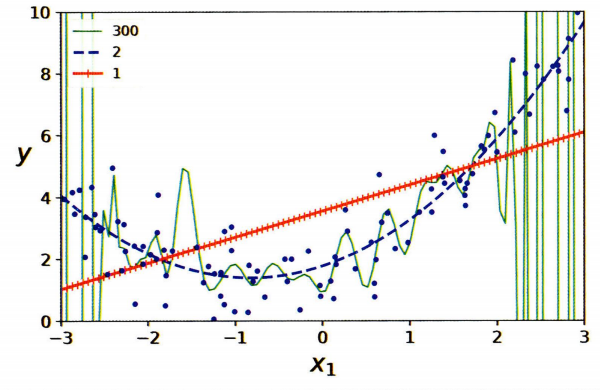


- 이 고차다항회귀모델은 심각하게 훈련데이터에 과대적합되었다. 반면에 선형모델은 과소적합이다. 이 경우 가장 일반화가 잘 된 모델은 2차다항회귀이다.
- 2장에서 모델의 일반화 성능을 추정하기 위해 **교차 검증**을 사용했다. 훈련데이터에서 성능이 좋지만 교차검증 점수가 나쁘다면 모델이 과대적합된 것이다. 만약 양쪽에 모두 좋지 않으면 과소적합이다. 이때 모델이 너무 단순하거나 너무 복잡하다고 말한다.

- 또다른 방법은 **학습곡선**을 살펴보는 것이다. 이 그래프는 훈련세트와 검증 세트의 모델 성능을 훈련세트 크기의 함수로 나타낸다. 이 그래프를 생성하기 위해서는 단순히 훈련 데이터 세트에서 크기가 다른 서브세트를 만들어 모델을 여러 번 훈련시키면 된다.
- 다음 코드는 주어진 훈련데이터에서 모델의 학습 곡선을 그리는 함수를 정의한다.

In [91]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model,X,y): # 데이터가 1개씩, 2개씩, 3개씩,... 이렇게 늘리는듯하다
  X_train, X_val, y_train,y_val = train_test_split(X,y,test_size=0.2)
  train_errors, val_errors =[],[]
  for m in range(1,len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Train Set")
  plt.plot(np.sqrt(val_errors), "b-+", linewidth=3, label="Validation Set")
  plt.legend()

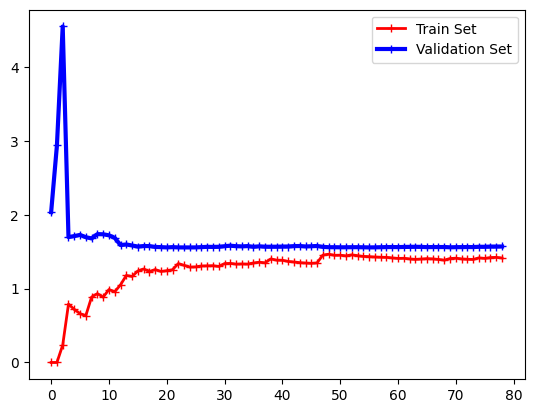

In [92]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

- 이 모델은 과소적합되었다.
- 훈련 데이터셋의 그래프는 0에서 시작하므로 훈련세트에 하나 혹은 두개의 샘플이 있을 때는 모델이 완벽하게 작동한다. 하지만 훈련세트에 샘플이 추가됨에 따라 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능해니다. 그래서 곡선이 어느 정도 평편해질 때까지 오차가 계속 상승한다. 이 위치에서는 훈련 세트에 샘플이 추가되어도 평균 오차가 크게 나아지거나 나빠지지 않는다.
- 검증데이터에 대한 모델의 성능 그래프를 보면 모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화될 수 없어 검증 오차가 초기에는 매우 크다. 모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소한다. 하지만 선형회귀의 직선은 데이터를 잘 모델링할 수 없으므로 오차의 감소가 완만해져서 훈련세트의 그래프와 가까워진다.
- 이 학습 곡선은 과소적합 모델의 전형적인 모습이다. 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해있다.
---
- 이제 같은 데이터에서 10차 다항회귀 모델의 학습곡선을 그려보겠다.

(0.0, 3.0)

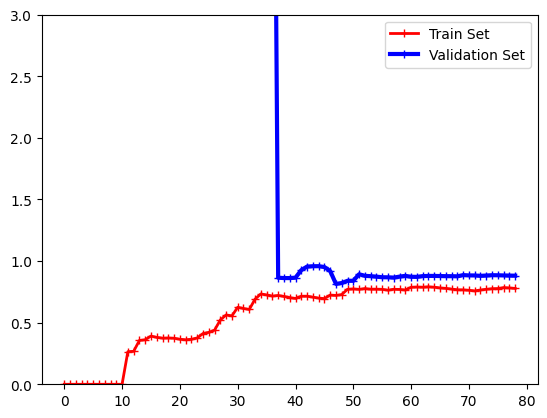

In [93]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias = False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X,y)
plt.ylim(0,3)

- 이 학습곡선은 이전과 비슷해 보이지만 두가지 매우 중요한 차이점이 있다.
> 1. 훈련 데이터의 오차가 선형회귀 모델보다 훨씬 낮다
> 2. 두 곡선 사이에는 공간이 있다. 이 말은 훈련데이터에서의 모델 검증이 데이터에서보다 훨씬 낫다는 뜻이다. 이는 과대적합 모델의 특징이다. 그러나 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워진다.
- 과대적합 모델을 개선하는 한가지 방법은 검증오차가 훈련오차에 근접할 때까지 더 많은 훈련 데이터를 추가하는 것이다.


#### 편향/분산 트레이드오프
모델의 일반화 오차는 세 가지 서로 다른 종류의 오차의 합으로 표현할 수 있다.

- **편향**

일반화 오차 중에서 편향은 잘못된 가정으로 인한 것이다. 예를 들어 데이터가 실제로는 2차인데 선형으로 가정하는 경우이다. 편향이 큰 모델은 훈련데이터에서 과소적합되기 쉽다.


- **분산**

분산(variance)은 훈련데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타난다. 자유도가 높은 모델(예를 들면 고차다항회귀모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있다.

- **줄일 수 없는 오차**

줄일 수 없는 오차(irreducible error)는 데이터 자체에 있는 잡음 때문에 발생한다. 이 오차를 줄일 수 있는 유일한 방법은 데이터에서 잡음을 제거하는 것이다(예를 들어 고장난 센서같은 데이터 소스를 고치거나 이상치를 감지해 제거한다).


=> 모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향은 줄어든다. 반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아진다. 그래서 트레이드오프라고 한다.

## 4.5 규제가 있는 선형모델
- 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것이다(즉, 모델을 제한하는 것이다). 자유도를 줄이면 데이터에 과대적합되기 더 어려워진다. 다항회귀모델을 규제하는 가장 간단한 방법은 다항식의 차수를 감소시키는 것이다.

선형회귀모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가한다. 각기 다른 방법으로 가중치를 제한하는 '릿지'회귀, '라쏘'회귀, 엘라스틱넷을 살펴보자

### 4.5.1 릿지 회귀
릿지회귀(또는 티호노프 규제)는 규제가 추가된 선형회귀 버전이다. 규제항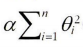이 비용함수에 추가된다. 이는 학습알고리즘을 데이터에 맞추는 것뿐만이 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력한다. 규제항은 훈련하는 동안에만 비용함수에 추가된다. 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능지표로 평가한다.

- 하이퍼파라미터 a(알파)는 모델을 얼마나 많이 규제할지 조절한다. a=0이면 릿지회귀는 선형회귀와 같아진다. a가 아주 크면 모든 가중치가 거의 0에 수렴하고 결국 데이터의 평균을 지나는 수평선이 된다.
- 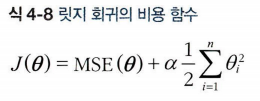

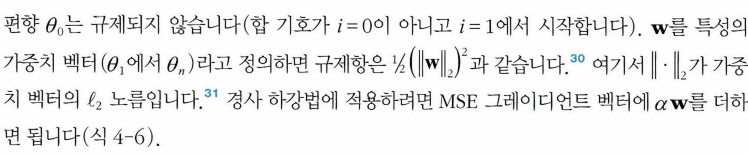
- 릿지 회귀는 입력 특성의 스케일에 민감하므로 수행하기 전에 데이터의 스케일을 맞우는 것이 매우 중요하다(StandardScaler 이용). 규제가 있는 모델은 대부분 그러하다.

- 다음은 선형데이터에 몇가지 다른 a를 적용하여 릿지모델을 훈련시킨 결과이다. 왼쪽 그래프는 평범한 릿지모델을 사용해 선형적 예측을 만들었다. 오른쪽 그래프는 PolynomialFeatures(degree=10)을 사용해 데이터를 확장하고 StandardScaler를 사용해 스케일을 조정한 후 릿지 모델을 적용했다. 이는 릿지 규제를  사용한 다항회귀가 된다. a를 증가시킬수록 직선에 가까워진다. 즉, 모델의 분산은 감소하고 편향은 증가한다.

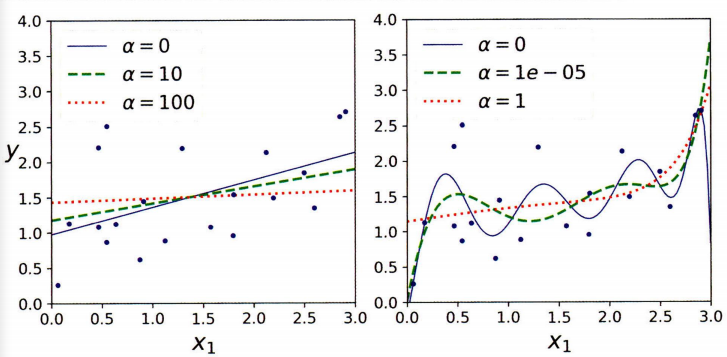



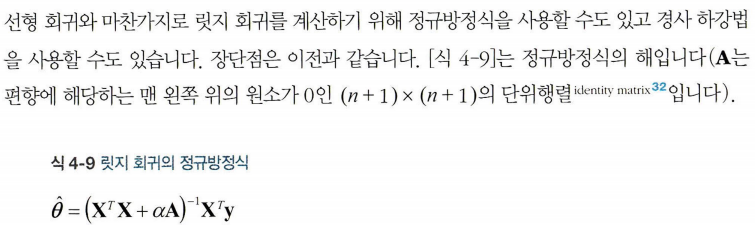

- 다음은 사이킷런에서 정규방정식을 사용한 릿지회귀를 적용하는 예이다. 행렬분해를 사용하여 위 식을 변형한 방정식을 사용한다.

In [94]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[4.64252464]])

- 다음은 확률적 경사하강법을 이용했을 때이다.

In [97]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([4.61766758])

- penalty 매개변수는 사용할 규제를 지정한다. "l2"는 SGD가 비용합수에 가중치 벡터의 노름의 제롭을 2로 나눈 규제항을 추가하게 만든다. 즉, 릿지회귀와 같다.

### 4.5.2 라쏘 회귀
- **라쏘 회귀**는 선형회귀의 또다른 규제된 버전이다. 릿지회귀처럼 비용함수에 규제항을 더하지만, 노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 노름을 사용힌다.
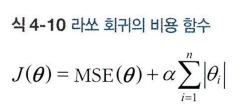

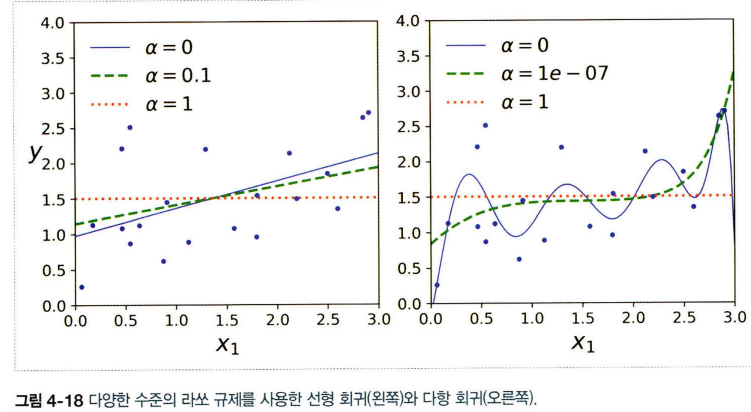

- 라쏘 회귀의 중요한 특성은 덜 중요한 특성의 가중치를 제거하려고 한다는 것이다. 라쏘 회귀는 자동으로 특성 선택을 하고 **희소 모델** sparse model 을 만든다. 즉, 0이 아닌 특성의 가중치가 적다.

- 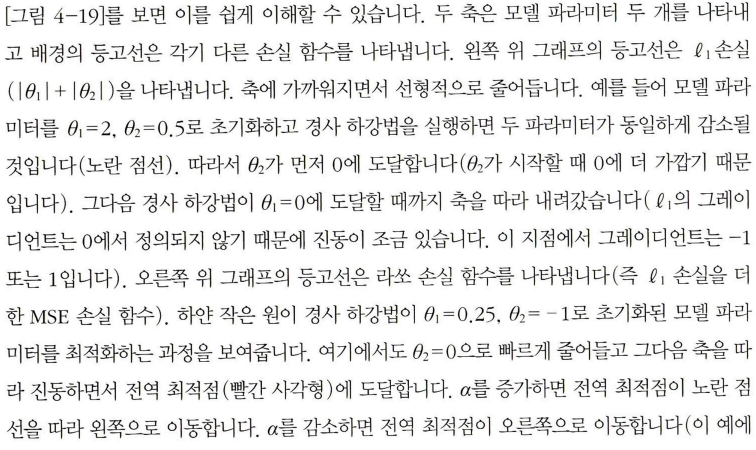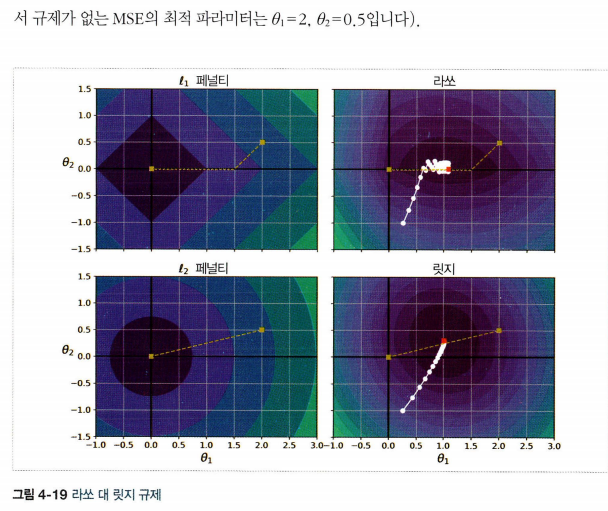

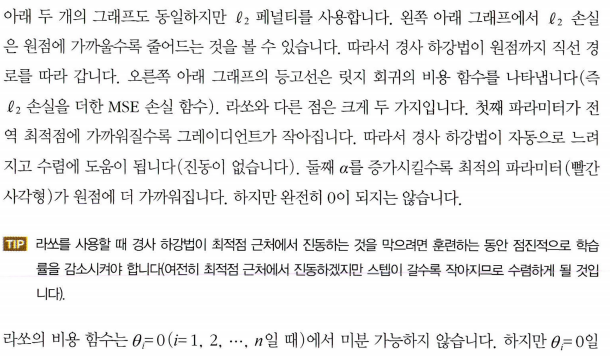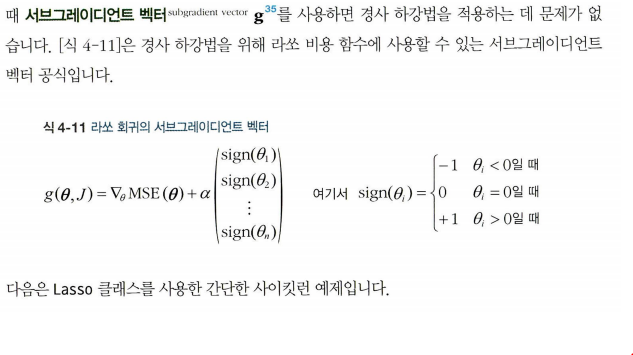

In [98]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([4.5844919])

- Lasso 대신 SGDRegressor(penalty="l1")을 사용할 수도 있다.

### 4.5.3 엘라스틱넷
- **엘라스틱넷**은 릿지회귀와 랏쏘회귀를 절충한 모델이다. 규제항은 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼한 정도는 혼합비율 r을 사용해 조절한다.
> -  r=0 : 릿지 회귀
> -  r=1 : 라쏘 회귀

---
- 릿지,라쏘,엘라스틱넷을 언제 사용해야 할까?
> - 평범한 선형회귀에서는 보통 사용하지 않는다.
> -  릿지가 기본이 되지만 쓰이는 특성이 몇개뿐이라고 의심되면 라쏘나 엘라스틱넷이 낫다. 이 모델들은 가중치를 0으로 만들어주기 때문이다.

> - 특성 수가 훈련 샘플 수보다 많거나 특성 몇개가 강하게 연관되어 있을 때는 보통 라쏘보다 엘라스틱넷을 선호한다.
---
- 다음은 사이킷런의 ElasticNet을 사용한 간단한 예제이다. l1_ratio 가 혼합비율 r이다.

In [99]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio = 0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.58782523])

### 4.5.4 조기 종료
- 경사하강법과 같은 반복적이 학습 알고리즘을 규제하는 다른 방식은 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것이다. 이를 **조기종료** early stopping이라고 한다. 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련세트에 대한 예측에러(RMSE)와 검증세트에 대한 예측에러가 줄어든다. 그러나 잠시 후 감소하던 검증에러가 멈추었다가 다시 상승한다. 이는 모델이 훈련데이터에 과대적합되기 시작하는 것을 의미한다. 조기 종료는 검증 에러가 최소에 도달하는 즉시 훈련을 멈추는 것이다.

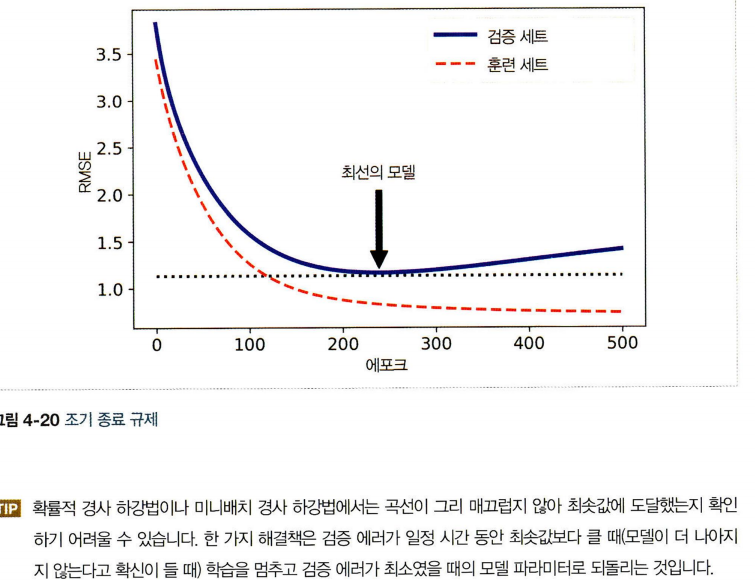

- 다음은 조기종료를 위한 기본적인 구현코드이다.

In [107]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train) # 훈련을 이어서 진행합니다.
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    best_epoch = epoch
    best_model = clone(sgd_reg)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

- warm_start= True로 지정하면 fit()메서드가 호출될 때부터 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어간다

## 4.6 로지스틱 회귀
- **로지스틱 회귀**는 샘플이 특정 클래스에 속할 확률을 추정하는 데에 널리 사용된다. 이를 이진분류기라고 한다

### 4.6.1 확률 추정
- 로지스틱 회귀는 입력 특성값의 가중치합을 계산한다. 그리고 편향을 더한다. 대신 선형회귀처럼 바로 결과를 출력하지 않고 결괏값의 로지스틱을 출력한다.

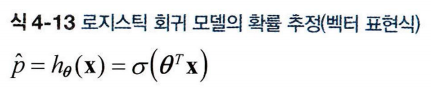

- 로지스틱은 0과 1사이의 값을 출력하는 시그모이드 함수이다. 이 식은 다음과 같이 정의된다.

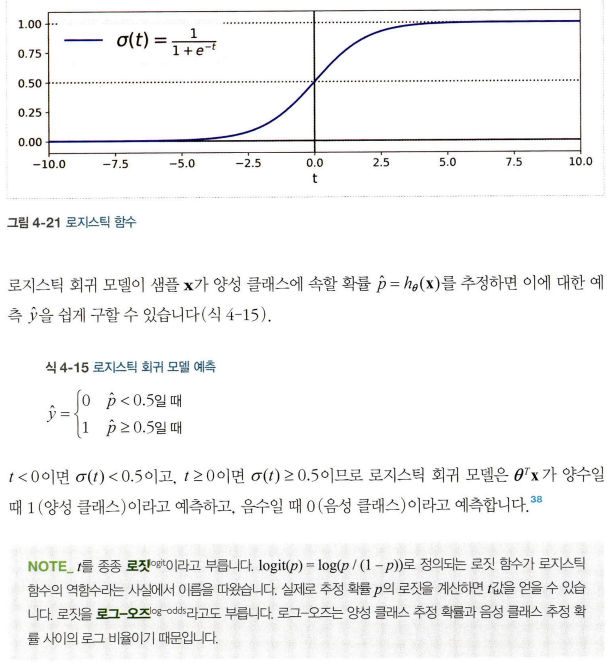

### 4.6.2 훈련과 비용함수
- 훈련의 목적은 양성 샘플(y=1)에 대해서는 높은 확률을 추정하고 음성 샘플(y=1)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 세타를 찾는 것이다.
- 전체 훈련 세트에 대한 비용함수는 모든 훈련샘플의 배용을 평균한 것이다. 이를 로그손실이라 부른다. 이는 볼록함수이므로 경사하강법을 통해 전역 최솟값을 구할 수 있다. 확률적 경사하강법은 한번에 하나의 샘플을 이용하고 미니배치 경사하강법은 한번에 하나의 미니배치를 사용한다.

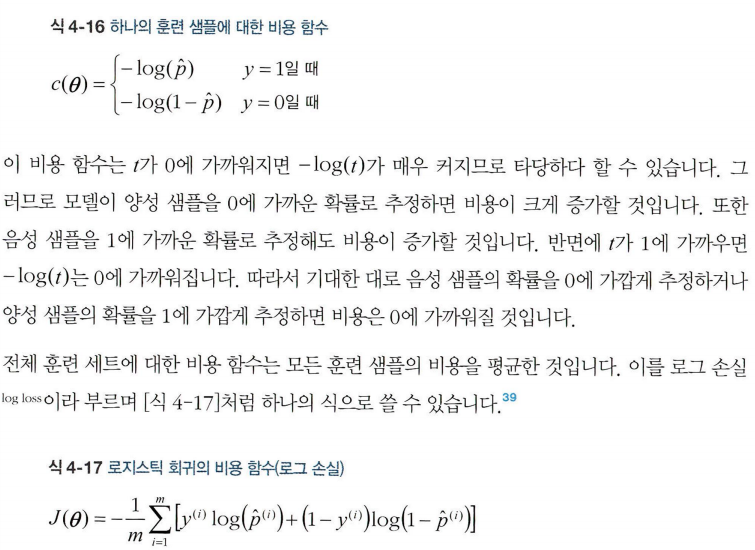

### 4.6.3 결정경계
- 로지스틱 회귀를 설명하기 위해 붓꽃데이터셋을 이용한다.
- 꽃잎의 너비를 기반으로 Iris-Versicolor종을 감지하는 분류기를 만들어보겠다.

In [111]:
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))
X= iris["data"][:,3:] # 꽃잎의 너비
y= (iris["target"]==2).astype('int') # 1 Iris-Virginica면 1, 그렇지 않으면 0

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module']


In [112]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률을 계산해보겠다.

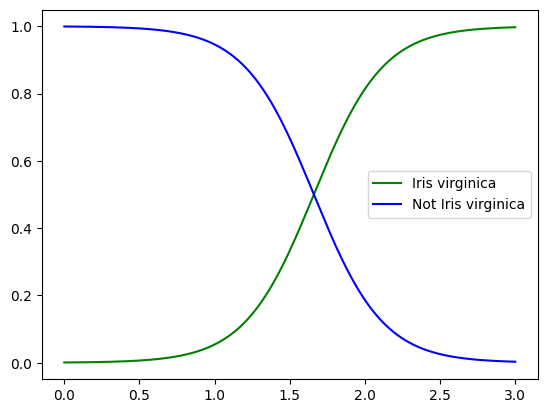

In [115]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1],"g-", label="Iris virginica")
plt.plot(X_new, y_proba[:,0],"b-", label="Not Iris virginica")
plt.legend()

In [117]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

- 다른 선형모델처럼 로지스틱회귀도 l1,l2 페널티를 사용하여 규제할 수 있다. 사이킷런은 l2 페널티를 기본으로 한다.

### 4.6.4 소프트맥스 회귀
- **소프트맥스 회귀**는 이진 분류인 로지스틱회귀와 달리 다중 클래스를 지원한다. **다항 로지스틱 회귀**라고도 한다.
- 로지스틱 회귀의 비용함수는 크로스 엔트로피라고 한다. 딱 두개의 클래스가 있을 때 이 비용함수는 로지스틱 회귀의 비용함수와 같다

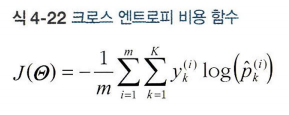

- multi_class 매개변수를 "multinomial"로 바꾸면 소프트맥스 회귀를 사용할 수 있다. 소프트맥스 회귀를 사용하려면 solver 매개변수에 "lbfgs"와 같이 소프트맥스 회귀를 지원하는 알고리즘을 지정해야 한다. 소프트맥스 회귀에는 기본저그올 하이퍼파라미터 C를 사용하여 조절할 수 있는 l2규제가 적용된다.

In [119]:
X= iris["data"][:,(2,3)] # 꽃잎 길이, 꽃잎 너비
y= iris["target"]

softmax_reg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [121]:
print(softmax_reg.predict([[5,2]]))
softmax_reg.predict_proba([[5,2]])

[2]


array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])